```{contents}
```
## Exit Node

An **Exit Node** in LangGraph represents the **terminal point of execution** for a workflow graph.
It marks the moment when the system has **completed its objective**, all required computation is finished, and the **final state is returned to the caller**.

In LangGraph, the exit node is represented by the built-in symbol:

```python
from langgraph.graph import END
```

---

### **1. Conceptual Role of the Exit Node**

LangGraph models computation as a **state machine**.
The Exit Node is the **accepting state** of that machine.

| Aspect      | Meaning                        |
| ----------- | ------------------------------ |
| Termination | No further nodes will execute  |
| Finality    | State is frozen and returned   |
| Correctness | Guarantees workflow completion |
| Safety      | Prevents infinite execution    |

Without an exit node, a graph is **ill-defined**.

---

### **2. How Exit Nodes Work**

An exit node is not a normal node function.
It is a **control symbol** that stops execution.

```
[ Node A ] → [ Node B ] → [ END ]
```

Once `END` is reached:

* Execution halts
* The **current state** is returned
* Checkpointing is finalized
* No further edges are evaluated

---

### **3. Declaring an Exit Path**

```python
builder.add_edge("final_step", END)
```

This declares that when `final_step` finishes, the workflow **must terminate**.

---

### **4. Exit via Conditional Logic**

Exit nodes are most powerful when combined with conditions.

```python
def router(state):
    if state["complete"]:
        return END
    return "process"
```

```python
builder.add_conditional_edges("check", router, {
    "process": "process",
    END: END
})
```

This enables **dynamic termination** based on runtime state.

---

### **5. Minimal Working Example**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    n: int

def step(state):
    return {"n": state["n"] + 1}

def decide(state):
    if state["n"] >= 3:
        return END
    return "step"

builder = StateGraph(State)

builder.add_node("step", step)
builder.add_node("decide", decide)

builder.set_entry_point("step")
builder.add_edge("step", "decide")
builder.add_conditional_edges("decide", decide, {"step": "step", END: END})

graph = builder.compile()
print(graph.invoke({"n": 0}))
```

**Execution path:**

```
0 → 1 → 2 → 3 → END
```

---

### **6. Variants of Exit Usage**

| Variant          | Purpose                       |
| ---------------- | ----------------------------- |
| Fixed Exit       | Always end after final node   |
| Conditional Exit | End when goal reached         |
| Early Exit       | Abort on failure              |
| Multi-Exit       | Different terminal conditions |
| Human Exit       | Stop after approval           |

---

### **7. Exit Nodes in Production Systems**

| Use Case          | Exit Behavior                |
| ----------------- | ---------------------------- |
| Autonomous agents | Stop when objective achieved |
| Human-in-loop     | Exit after approval          |
| Compliance flows  | Exit after validation        |
| Long-running jobs | Exit on timeout or success   |
| Error recovery    | Exit on fatal error          |

---

### **8. Exit Nodes vs Failure States**

Exit nodes do **not** imply success or failure.
They indicate **termination**.

Design pattern:

| Path               | Meaning               |
| ------------------ | --------------------- |
| Normal path → END  | Successful completion |
| Error path → END   | Controlled failure    |
| Timeout path → END | Graceful termination  |

---

### **9. Mental Model**

An Exit Node is equivalent to:

> `return final_state` in a function

It converts a **running graph** into a **completed result**.

---

### **10. Design Best Practices**

* Every graph must have at least one reachable `END`
* Cyclic graphs must include **safe exit conditions**
* Production graphs should support:

  * success exit
  * failure exit
  * timeout exit
  * human-abort exit



In [2]:
from typing import TypedDict

class State(TypedDict):
    value: int
    error: bool
    approved: bool

from langgraph.graph import StateGraph, END

def increment(state: State):
    return {"value": state["value"] + 1}

def validate(state: State):
    if state["value"] > 5:
        return {"error": True}
    return {"error": False}

def human_review(state: State):
    # Simulated approval logic
    if state["value"] == 3:
        return {"approved": True}
    return {"approved": False}

def router(state: State):
    if state["error"]:
        return "error_exit"
    if state["approved"]:
        return "success_exit"
    if state["value"] >= 4:
        return "timeout_exit"
    return "increment"

builder = StateGraph(State)

builder.add_node("increment", increment)
builder.add_node("validate", validate)
builder.add_node("review", human_review)

# Entry
builder.set_entry_point("increment")

# Flow
builder.add_edge("increment", "validate")
builder.add_edge("validate", "review")

# Conditional exit logic
builder.add_conditional_edges("review", router, {
    "increment": "increment",
    "error_exit": END,
    "success_exit": END,
    "timeout_exit": END
})

graph = builder.compile()

In [3]:
result = graph.invoke({"value": 0, "error": False, "approved": False})
print(result)

{'value': 3, 'error': False, 'approved': True}


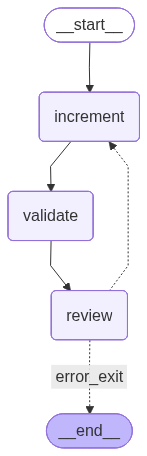

In [4]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())